In [1]:
import pathlib
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import cartopy
import elevation
import xarray as xr
from itertools import combinations
from more_itertools import pairwise
from netCDF4 import Dataset
from visualisation_utils import plot_colormap_from_dataset, \
    plot_wind_components_from_dataset, plot_wind_components_from_different_datasets, process_station_txt_file_from_MeteoSwiss, distance_from_coordinates, HigherResPlateCarree

data_path = pathlib.Path("../data")
warnings.filterwarnings('ignore')

# ERA5 Data

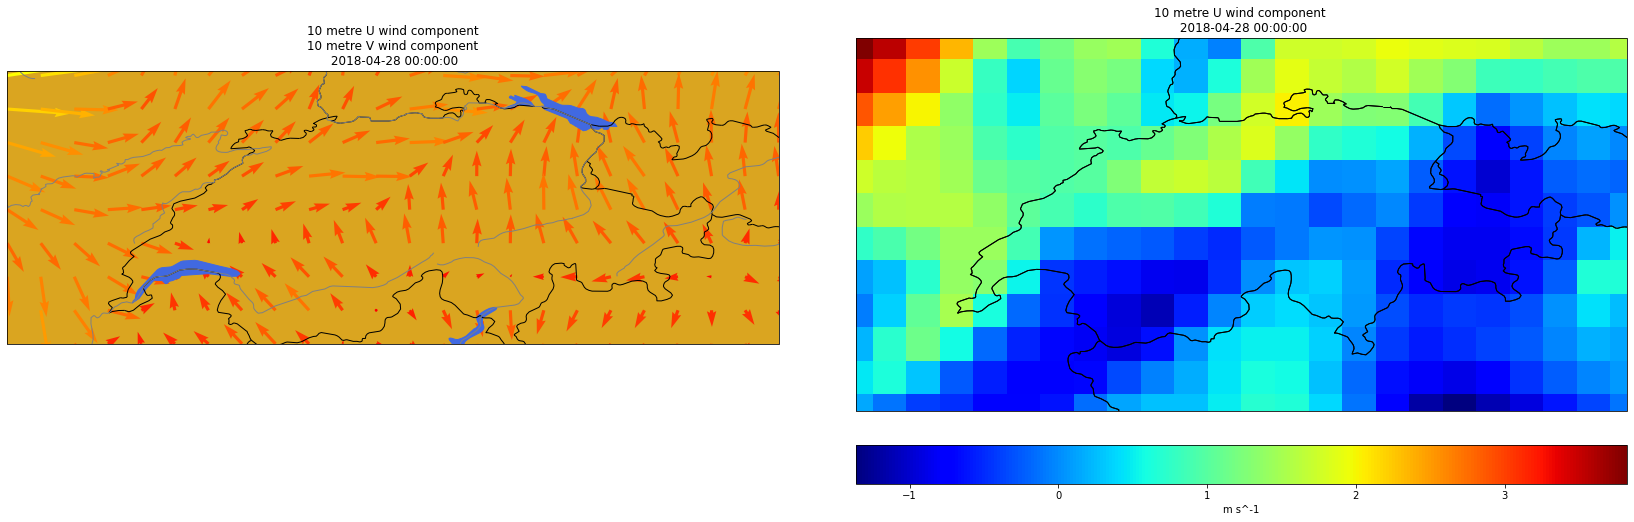

In [2]:
file = data_path.glob('ERA5/*surface*.nc').__next__()
data = Dataset(file, mode='r')  # read the data

range_long = (5.1, 11.2)
range_lat = (45.7, 48.1)

subplot_kw = {'projection': HigherResPlateCarree()}
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw=subplot_kw, figsize=(25,12.5))
fig.subplots_adjust(wspace=0.1, left=0.05, right=0.95)
plot_wind_components_from_dataset(data, 0, 'u10', 'v10',
                                  range_lon=range_long, range_lat=range_lat,
                                  ax=ax1)
plot_colormap_from_dataset(data, 0, 'u10', ax=ax2)
fig.show()

# NASA-GISS-E2-R CMIP5 RCP4.5 Data

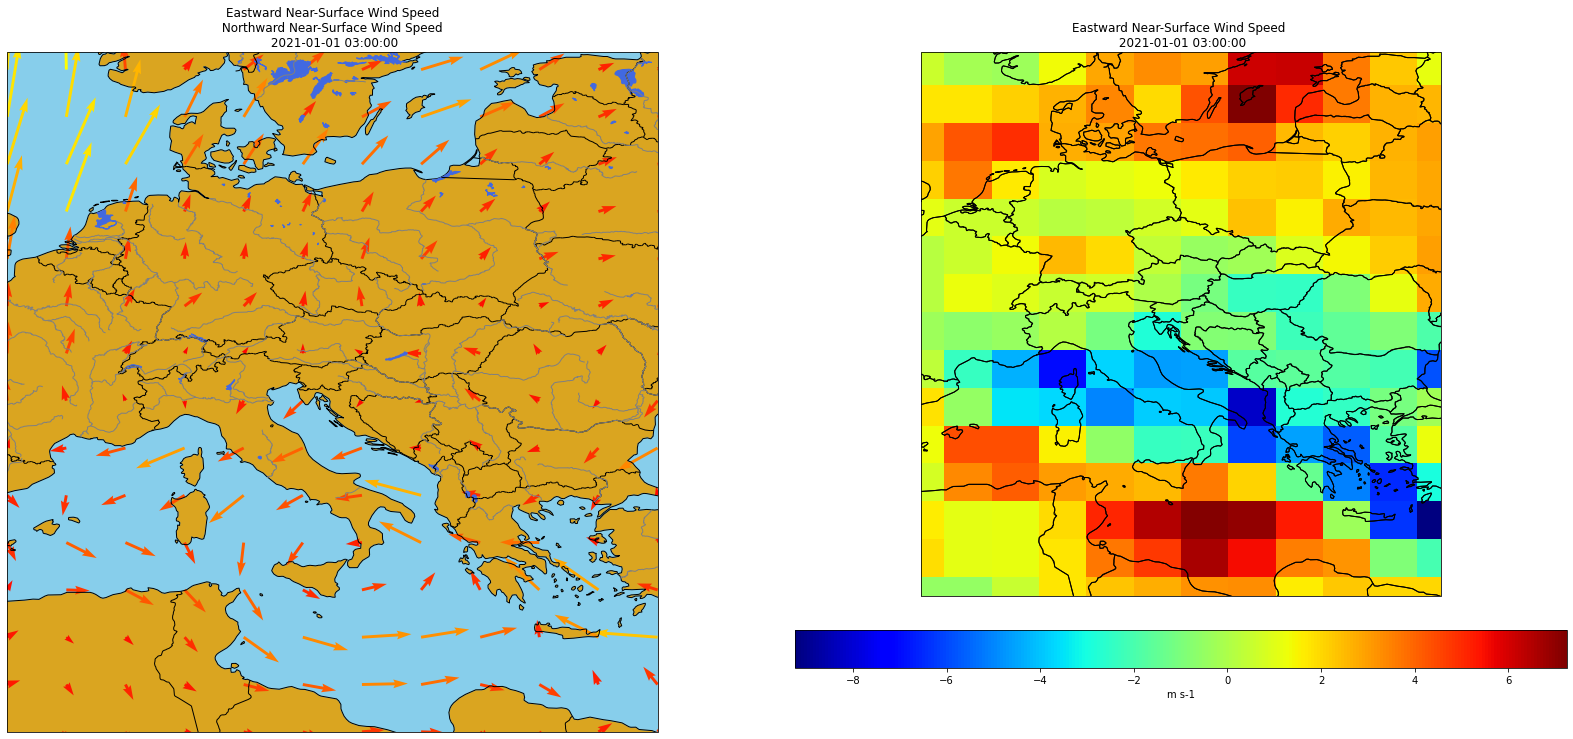

In [3]:
file_uas = data_path.glob("NASA-GISS-E2-R/rcp45/uas*.nc").__next__()
d1 = Dataset(file_uas, mode='r')  # read the data
file_vas = data_path.glob("NASA-GISS-E2-R/rcp45/vas*.nc").__next__()
d2 = Dataset(file_vas, mode='r')

range_long = (0 , 30)
range_lat = (30, 60)

subplot_kw = {'projection': HigherResPlateCarree()}
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw=subplot_kw, figsize=(25, 12.5))
fig.subplots_adjust(wspace=0.1, left=0.05, right=0.95)
plot_wind_components_from_different_datasets(d1, d2, 0, 'uas', 'vas',
                                             range_lon=range_long,
                                             range_lat=range_lat,
                                             ax=ax1)
plot_colormap_from_dataset(d1, 0, 'uas', range_lon=range_long,
                                             range_lat=range_lat, ax=ax2)
fig.show()


# MeteoSwiss Observations

In [4]:
file_obs = pathlib.Path(data_path, 'MS_observations/wind_2016_2021_processed.csv')
file_station = pathlib.Path(data_path, 'MS_observations/stations.txt')

In [5]:
obs = pd.read_csv(file_obs)
obs.head(5)

,station,datetime,station_name,data_source,altitude_m,lon,lat,closest_lon,closest_lat,x_km,...,tpi_500,tpi_1000,tpi_2000,wind_speed_mps,wind_direction_degrees,theta_radians,u10,v10,wind_gust_mps,altitude_bins
0,ABO,2019-01-03 11:00:00,Adelboden,MeteoSchweiz,1321.0,7.566667,46.5,7.56625,46.499583,609372.0,...,-22.5,-37.794678,-46.815918,1.9,196.0,1.088889,0.880593,1.683614,NaN,"(1028.0, 1638.0]"
1,ABO,2018-08-18 19:00:00,Adelboden,MeteoSchweiz,1321.0,7.566667,46.5,7.56625,46.499583,609372.0,...,-22.5,-37.794678,-46.815918,1.2,114.0,0.633333,0.967271,0.710202,NaN,"(1028.0, 1638.0]"
2,ABO,2018-08-18 20:00:00,Adelboden,MeteoSchweiz,1321.0,7.566667,46.5,7.56625,46.499583,609372.0,...,-22.5,-37.794678,-46.815918,1.2,80.0,0.444444,1.083420,0.515948,NaN,"(1028.0, 1638.0]"
3,ABO,2018-08-18 21:00:00,Adelboden,MeteoSchweiz,1321.0,7.566667,46.5,7.56625,46.499583,609372.0,...,-22.5,-37.794678,-46.815918,0.7,158.0,0.877778,0.447204,0.538525,NaN,"(1028.0, 1638.0]"
4,ABO,2018-08-18 22:00:00,Adelboden,MeteoSchweiz,1321.0,7.566667,46.5,7.56625,46.499583,609372.0,...,-22.5,-37.794678,-46.815918,0.9,203.0,1.127778,0.385802,0.813116,NaN,"(1028.0, 1638.0]"


In [6]:
def pct_data_available(x: pd.Series):
    return 100*x.count()/len(x)

def plot_stations(ax, stations):
    proj = HigherResPlateCarree()
    ax = plt.axes(projection=proj)
    ax.set_extent([stations.lon.min()-0.3, stations.lon.max()+0.3, stations.lat.min()-0.3, stations.lat.max()+0.3])
    ax.coastlines()
    ax.stock_img()
    ax.add_feature(cartopy.feature.LAND, color='goldenrod')
    ax.add_feature(cartopy.feature.LAKES.with_scale('10m'), color='royalblue')
    ax.add_feature(cartopy.feature.OCEAN, color='skyblue')
    ax.add_feature(cartopy.feature.BORDERS.with_scale('10m'), color='black')
    ax.add_feature(cartopy.feature.RIVERS.with_scale('10m'), color='grey')
    c_scheme = ax.scatter(x=stations.lon, y=stations.lat,
                s=150,
                c=stations.altitude_m,
                cmap='Reds',
                alpha=0.5,
                transform=HigherResPlateCarree())
    plt.colorbar(c_scheme, location='bottom', pad=0.07,
                 label='Altitude (m)', ax=ax)
    for s, d in stations.groupby('station'):
        ax.text(d.lon+0.1, d.lat-0.04, s, transform=HigherResPlateCarree(),
                fontsize=10, c='black', horizontalalignment='center', verticalalignment='center')
        
def plot_correlation_between_stations(ax, stations_df, corr_df):
    to_concat = []
    proj = HigherResPlateCarree()
    ax = plt.axes(projection=proj)
    ax.set_extent([stations.lon.min()-0.3, stations.lon.max()+0.3, stations.lat.min()-0.3, stations.lat.max()+0.3])
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='goldenrod')
    ax.add_feature(cartopy.feature.LAKES.with_scale('10m'), color='royalblue')
    ax.add_feature(cartopy.feature.OCEAN, color='skyblue')
    ax.add_feature(cartopy.feature.BORDERS.with_scale('10m'), color='black')
    ax.add_feature(cartopy.feature.RIVERS.with_scale('10m'), color='grey')
    c_scheme = ax.scatter(x=stations.lon, y=stations.lat,
                s=150,
                c=stations.altitude_m,
                cmap='Reds',
                alpha=0.5,
                transform=HigherResPlateCarree())
    plt.colorbar(c_scheme, location='bottom', pad=0.07,
                 label='Altitude (m)', ax=ax)
    for s1, s2 in combinations(corr_df.columns,2):
        corr_abs = np.abs(corr_df.loc[s1, s2])
        lon1, lat1 = float(stations[stations['station']==s1].lon), float(stations[stations['station']==s1].lat)
        lon2, lat2 = float(stations[stations['station']==s2].lon), float(stations[stations['station']==s2].lat)
        d = distance_from_coordinates((lon1, lat1), (lon2, lat2))
        alt1 = float(stations[stations['station']==s1].altitude_m)/1000
        alt2 = float(stations[stations['station']==s2].altitude_m)/1000
        delta_alt = alt1-alt2
        true_d = np.sqrt(d**2+delta_alt**2)
        angle = np.arctan(np.abs(delta_alt)/d)
        to_concat.append(pd.DataFrame([[s1, s2, corr_df.loc[s1, s2], corr_abs,
                                       d, np.abs(delta_alt), true_d, np.abs(delta_alt)*d, angle]],
                                     columns=['s1', 's2', 'correlation', 'abs_correlation',
                                              'd', 'delta_altitude (km)',
                                              'distance (km)', 'product (km**2)', 'angle (deg)']))
        if true_d<=25:
            plt.plot([lon1, lon2], [lat1, lat2],
                 linewidth=0.1+5*corr_abs,
                 c = 'salmon',
                 transform=HigherResPlateCarree())
    for s, d in stations.groupby('station'):
        ax.text(d.lon+0.15, d.lat-0.04, s, transform=HigherResPlateCarree(),
                fontsize=10, c='black', horizontalalignment='center', verticalalignment='center')
    return pd.concat(to_concat)

<AxesSubplot:xlabel='station'>

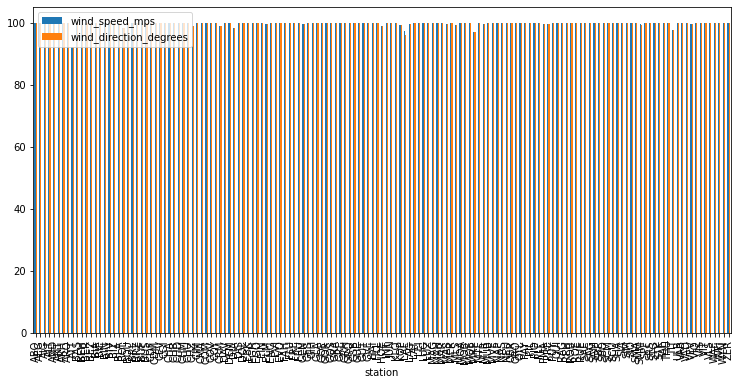

In [7]:
obs.groupby('station').agg({'wind_speed_mps': pct_data_available, 'wind_direction_degrees':pct_data_available})\
.plot(kind='bar', figsize=(12.5,6))

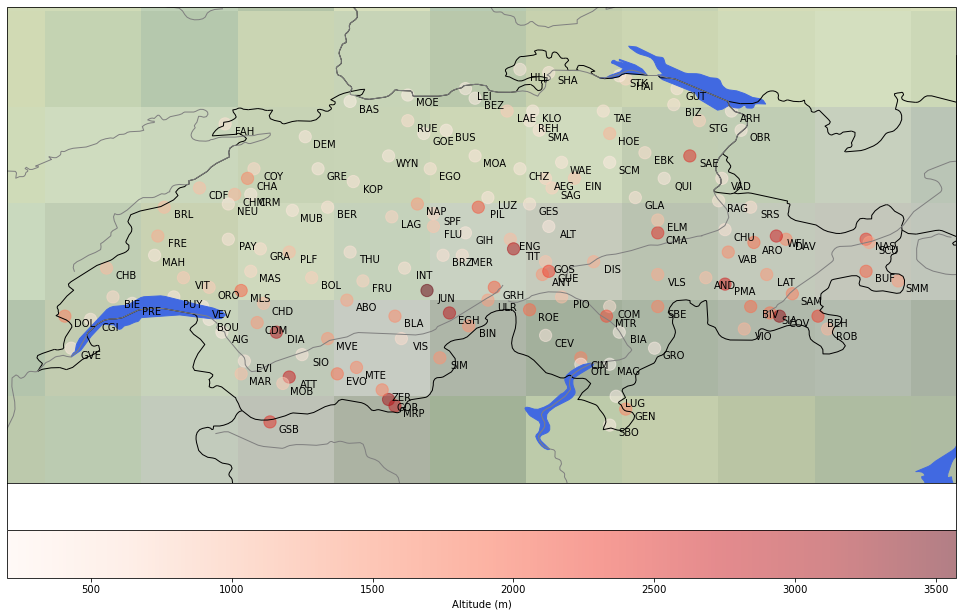

In [8]:
stations=process_station_txt_file_from_MeteoSwiss(file_station)\
.assign(enriched_name = lambda x: x['station_name'] + ' ('+ x['station'] + ')')
subplot_kw = {'projection': HigherResPlateCarree()}
fig, ax1 = plt.subplots(ncols=1, subplot_kw=subplot_kw, figsize=(17, 12.5))
plot_stations(ax1, stations)
fig.show()

## Wind Speed

Text(0, 0.5, 'wind speed (ms^-1)')

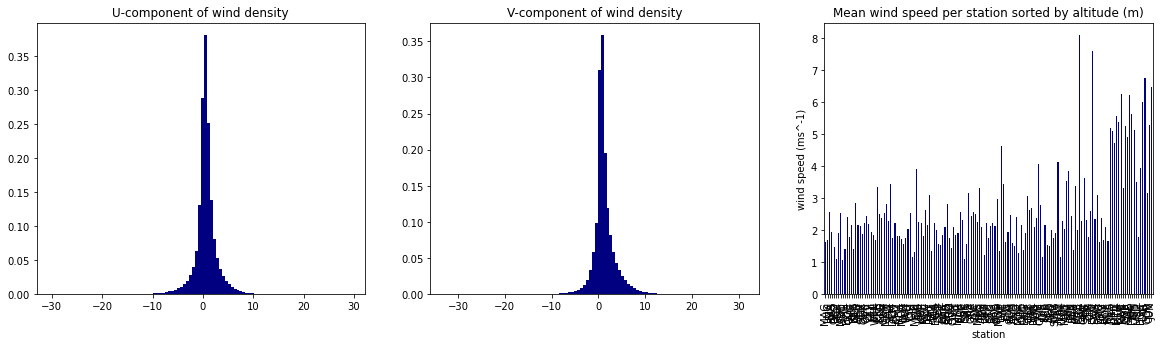

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(20,5))
ax1.hist(obs['u10'], density=True, color='navy', bins=100)
ax1.set_title('U-component of wind density')
ax2.hist(obs['v10'], density=True, color='navy', bins=100)
ax2.set_title('V-component of wind density')
obs.groupby('station').agg({'wind_speed_mps':'mean', 'altitude_m': lambda x: x.unique()})\
.sort_values(by='altitude_m')['wind_speed_mps'].plot(kind='bar', ax=ax3, color='navy')
ax3.set_title('Mean wind speed per station sorted by altitude (m)')
ax3.set_ylabel('wind speed (ms^-1)')

In [10]:
nb_bins = 10
obs['altitude_bins'] = pd.qcut(obs['altitude_m'],nb_bins)
obs['tpi_500_bins'] = pd.qcut(obs['tpi_500'],nb_bins)
obs['tpi_1000_bins'] = pd.qcut(obs['tpi_1000'],nb_bins)
obs['tpi_2000_bins'] = pd.qcut(obs['tpi_2000'],nb_bins)
obs['lon_bins'] = pd.qcut(obs['lon'],nb_bins)
obs['lat_bins'] = pd.qcut(obs['lat'],nb_bins)

Text(0.5, 1.0, 'Square root wind speed (ms^-1) density')

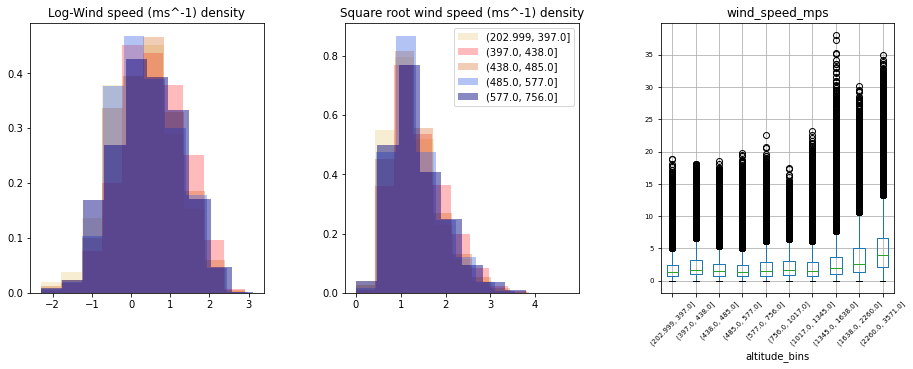

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(15,5))
for (ab, df), c, a in zip(obs.groupby('altitude_bins'), 
                          ['goldenrod', 'red', 'chocolate','royalblue', 'navy'],
                          np.linspace(0.2,0.8,nb_bins)):
    ax1.hist(np.log(df[df['wind_speed_mps']>0]['wind_speed_mps']), density=True, 
             label=ab, color=c, alpha=a)
    ax2.hist(np.sqrt(df['wind_speed_mps']), density=True,
             label=ab, color=c, alpha=a)
obs.boxplot(by='altitude_bins', column=['wind_speed_mps'], ax=ax3, rot=45, fontsize=7)
fig.suptitle('')
ax1.set_title('Log-Wind speed (ms^-1) density')
ax2.legend()
plt.subplots_adjust(wspace=0.35)
ax2.set_title('Square root wind speed (ms^-1) density')

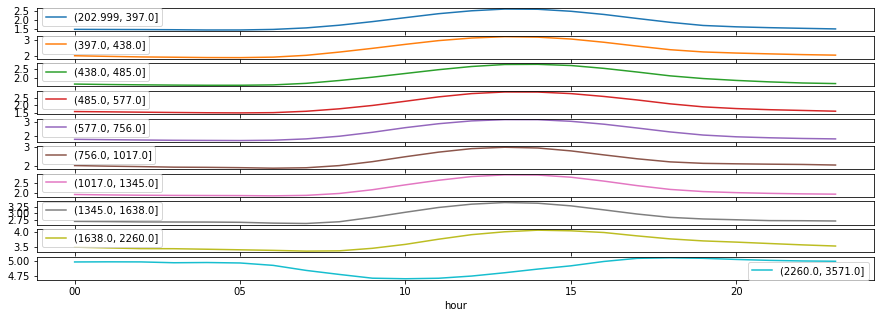

In [12]:
obs = obs.assign(hour = lambda x: x['datetime'].str[-8:])
obs['hour'] = obs['hour'].str[0:2]
obs.groupby(['hour', 'altitude_bins']).agg({'wind_speed_mps':'mean'})['wind_speed_mps'].unstack('altitude_bins').plot(subplots=True,
                                                                                                   sharex=True,
                                                                                                          figsize=(15,5))
plt.legend()

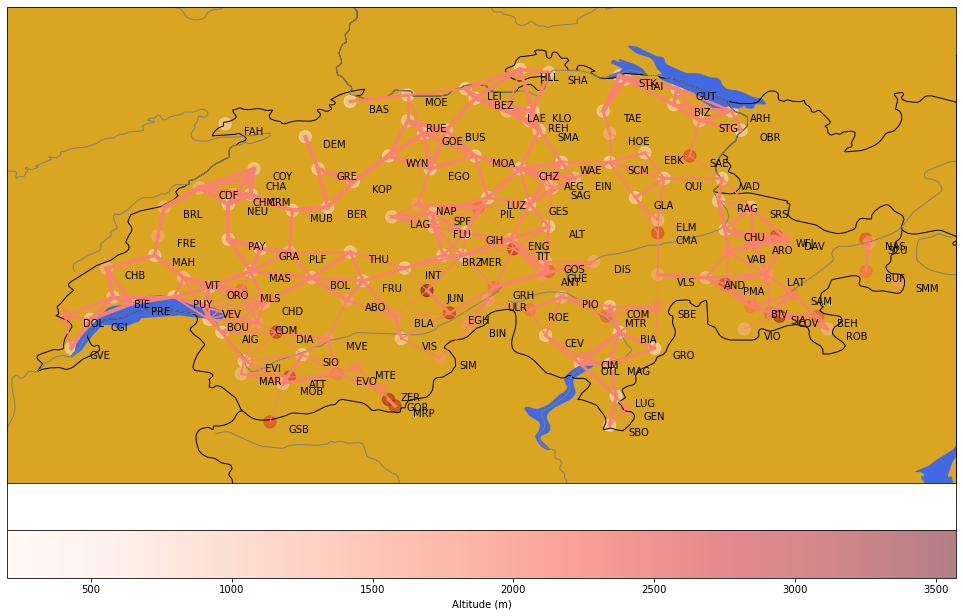

In [13]:
corr_wind_speed_stations = obs.set_index(['station', 'datetime'])['wind_speed_mps'].unstack('station').corr()
subplot_kw = {'projection': HigherResPlateCarree()}
fig, ax1 = plt.subplots(ncols=1, subplot_kw=subplot_kw, figsize=(17, 12.5))
df = plot_correlation_between_stations(ax1, stations, corr_wind_speed_stations)
fig.show()

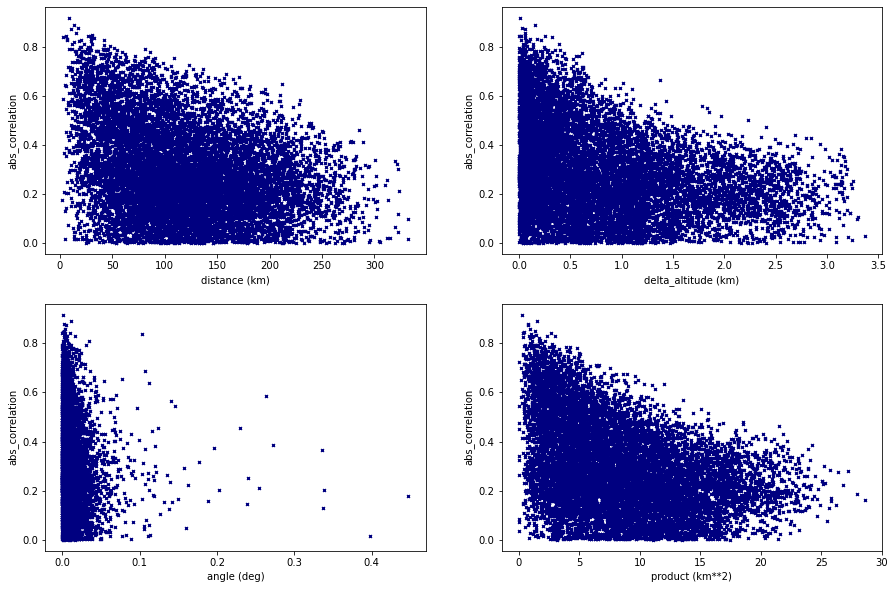

In [14]:
df_ = df
df_['product (km**2)'] = np.sqrt(df_['product (km**2)'])
corr_column = 'abs_correlation'
df_cols = ['distance (km)', 'delta_altitude (km)', 'angle (deg)', 'product (km**2)']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows=2, figsize=(15,10))
for ax, c in zip([ax1, ax2, ax3, ax4], df_cols):
    corr_df = df_[[c, corr_column]].sort_values(c)
    ax.scatter(corr_df[c], corr_df[corr_column],
            marker='x', s=8, color='navy')
    ax.set_xlabel(c)
    ax.set_ylabel(corr_column)

Wind speed seems impacted by altitude (increasing) and hour in the day (polynomial deg 2 with peak at noon, more or less fat tailed depending on altitude). Log wind speed could be considered Gaussian/Gamma?
Correlation depending on distance between places: not observed, it actually does not look very isotropic nor stationary in space and there could be space-time crossed-effects (JUN station is the highest and the daily wind pattern is different).

## Wind direction

Text(0.5, 1.0, 'Wind direction (rad) distribution per altitude bin')

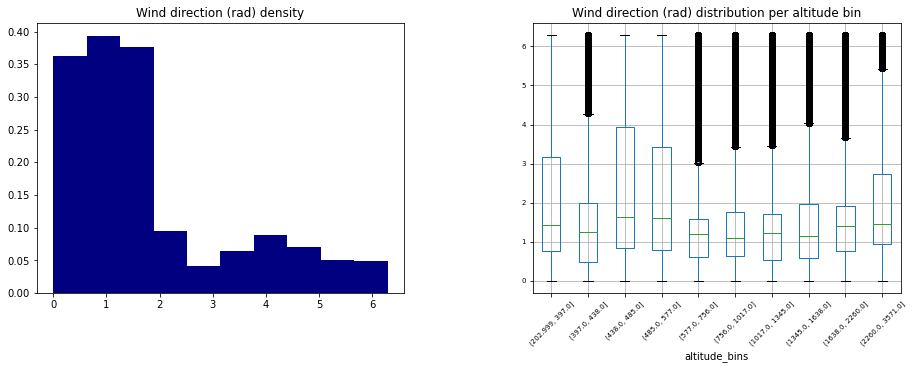

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
ax1.hist(obs['theta_radians'], density=True, color='navy')
obs.boxplot(by='altitude_bins', column=['theta_radians'], ax=ax2, rot=45, fontsize=7)
fig.suptitle('')
ax1.set_title('Wind direction (rad) density')
plt.subplots_adjust(wspace=0.35)
ax2.set_title('Wind direction (rad) distribution per altitude bin')

Wind direction almost Poisson-like wiht overdispersion for big values, obviously bounded, no effect from the altitude at first sight, although some variation depending on station. Perhaps it comes from the proximity of some stations?

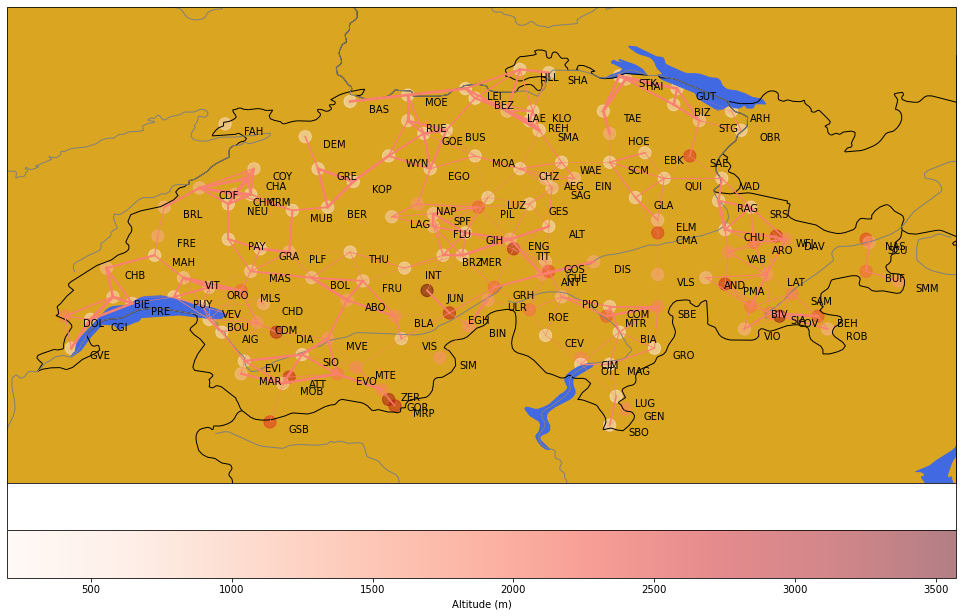

In [16]:
corr_wind_dir = obs.set_index(['station', 'datetime'])['theta_radians'].unstack('station').corr()
subplot_kw = {'projection': HigherResPlateCarree()}
fig, ax1 = plt.subplots(ncols=1, subplot_kw=subplot_kw, figsize=(17, 12.5))
df = plot_correlation_between_stations(ax1, stations, corr_wind_dir)
fig.show()

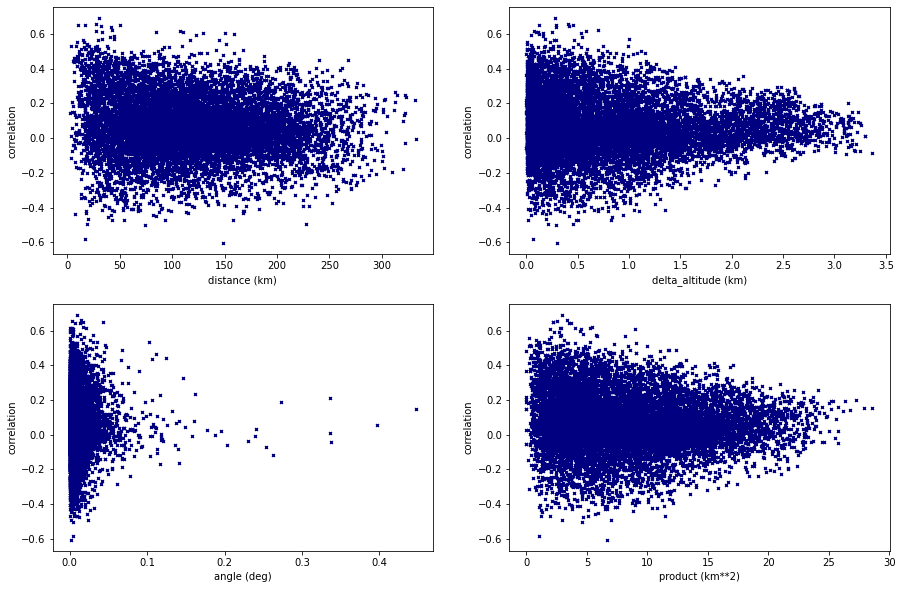

In [17]:
df_ = df
df_['product (km**2)'] = np.sqrt(df_['product (km**2)'])
corr_column = 'correlation'
df_cols = ['distance (km)', 'delta_altitude (km)', 'angle (deg)', 'product (km**2)']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows=2, figsize=(15,10))
for ax, c in zip([ax1, ax2, ax3, ax4], df_cols):
    corr_df = df_[[c, corr_column]].sort_values(c)
    ax.scatter(corr_df[c], corr_df[corr_column],
            marker='x', s=8, color='navy')
    ax.set_xlabel(c)
    ax.set_ylabel(corr_column)

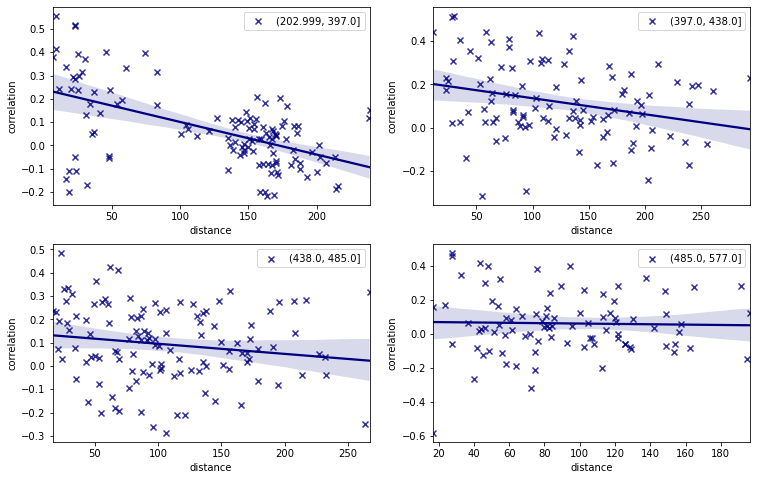

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12.5,8))
alt_index = 'altitude_bins'
distance_corr_dic_per_ab = {}
for ab in sorted(obs[alt_index].unique()):
    stations_ab = obs[obs[alt_index]==ab]['station'].unique()
    distance_corr_dic_per_ab[ab] = {}
    for s1, s2 in combinations(stations_ab,2):
        lon1, lat1 = float(stations[stations['station']==s1].lon), float(stations[stations['station']==s1].lat)
        lon2, lat2 = float(stations[stations['station']==s2].lon), float(stations[stations['station']==s2].lat)
        d = distance_from_coordinates((lon1, lat1), (lon2, lat2))
        distance_corr_dic_per_ab[ab][d] = corr_wind_dir.loc[s1, s2]
distance_corr_df_per_ab = pd.DataFrame.from_dict(distance_corr_dic_per_ab, orient='columns').sort_index()
for c, ax in zip(distance_corr_df_per_ab.columns, (ax1, ax2, ax3, ax4)):
    sns.regplot(x=distance_corr_df_per_ab.index, y=distance_corr_df_per_ab[c], ax=ax, 
                label=c, color='navy', marker='x')
    ax.legend()
    ax.set_xlabel('distance')
    ax.set_ylabel('correlation')

No isotropy there 

# Variables Selection

The areas of interest are:
- Europe -30 30 60 80
- Switzerland 5.1 45.7 11.2 48.1

In [19]:
data_path = '/Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE/data/point_prediction_files/train'
obs['date'] = pd.to_datetime(obs['date'])
start_train_period = pd.to_datetime('2016-01-10')
end_train_period = pd.to_datetime('2016-06-10')
data = []
for d in pd.date_range(start_train_period, end_train_period):
    d_str = d.strftime('%Y%m%d')
    x = f'{data_path}/x_train_{d_str}.npy'
    y = f'{data_path}/y_train_{d_str}.npy'
    #xarr = np.load(x)[:, :, 1, 1, ...]
    xarr = np.mean(np.load(x), axis=(2,3))
    m,n,r = xarr.shape
    xarr = np.column_stack((np.repeat(np.arange(m),n),xarr.reshape(m*n,-1)))
    yarr= np.load(y)[:, :, 0, 0, ...]
    m,n,r = yarr.shape
    yarr = np.column_stack((np.repeat(np.arange(m),n),yarr.reshape(m*n,-1)))
    out_df = pd.DataFrame(np.concatenate([xarr, yarr[:, 1:]], axis=-1), columns = ['station',
                                          'u10', 'v10', 'blh', 'fsr', 'sp',
                                         'z',
                                         'tpi_500', 'aspect', 'u10_hr', 'v10_hr'])
    out_df['hour'] = np.tile(np.arange(n), m)
    out_df['date'] = d
    out_df = out_df.assign(datetime = lambda x: x['date']+pd.to_timedelta(x['hour'], unit='H'))
    output_for_date = obs[obs['date']==d]
    station_column = 'station'
    complete_stations = output_for_date.groupby(station_column)['datetime'].nunique() == 24
    output_for_date = output_for_date[output_for_date[station_column].isin(complete_stations[complete_stations].index)]
    out_df['station'] = output_for_date.reset_index()[station_column]
    data.append(out_df)
data = pd.concat(data).merge(stations, on='station', how='left')
data.to_csv('/Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE/data/point_prediction_files/dataframe_6months.csv')

In [20]:
data_path = '/Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE/data/point_prediction_files/test'
obs['date'] = pd.to_datetime(obs['date'])
start_train_period = pd.to_datetime('2020-01-10')
end_train_period = pd.to_datetime('2020-01-13')
data = []
for d in pd.date_range(start_train_period, end_train_period):
    d_str = d.strftime('%Y%m%d')
    x = f'{data_path}/x_test_{d_str}.npy'
    y = f'{data_path}/y_test_{d_str}.npy'
    #xarr = np.load(x)[:, :, 1, 1, ...]
    xarr = np.mean(np.load(x), axis=(2,3))
    m,n,r = xarr.shape
    xarr = np.column_stack((np.repeat(np.arange(m),n),xarr.reshape(m*n,-1)))
    yarr= np.load(y)[:, :, 0, 0, ...]
    m,n,r = yarr.shape
    yarr = np.column_stack((np.repeat(np.arange(m),n),yarr.reshape(m*n,-1)))
    out_df = pd.DataFrame(np.concatenate([xarr, yarr[:, 1:]], axis=-1), columns = ['station',
                                          'u10', 'v10', 'blh', 'fsr', 'sp',
                                         'z',
                                         'tpi_500', 'aspect', 'u10_hr', 'v10_hr'])
    out_df['hour'] = np.tile(np.arange(n), m)
    out_df['date'] = d
    out_df = out_df.assign(datetime = lambda x: x['date']+pd.to_timedelta(x['hour'], unit='H'))
    output_for_date = obs[obs['date']==d]
    station_column = 'station'
    complete_stations = output_for_date.groupby(station_column)['datetime'].nunique() == 24
    output_for_date = output_for_date[output_for_date[station_column].isin(complete_stations[complete_stations].index)]
    out_df['station'] = output_for_date.reset_index()[station_column]
    data.append(out_df)
data = pd.concat(data).merge(stations, on='station', how='left')
data.to_csv('/Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE/data/point_prediction_files/dataframe_6months_test.csv')

In [21]:
data.columns

Index(['station', 'u10', 'v10', 'blh', 'fsr', 'sp', 'z', 'tpi_500', 'aspect',
       'u10_hr', 'v10_hr', 'hour', 'date', 'datetime', 'station_name',
       'data_source', 'altitude_m', 'lon', 'lat', 'x_km', 'y_km',
       'enriched_name'],
      dtype='object')

In [22]:
diff_col = 'u10'
diff_y = f'{diff_col}_hr'
diff = (data[diff_y] - data[diff_col]).to_frame().rename(columns={0: diff_col})
diff['datetime'] = data['datetime']

In [23]:
np.quantile(diff[diff_col].dropna(), np.linspace(0.01, 0.9))

array([-7.52543883, -5.04394239, -3.54508944, -2.58384429, -2.04201071,
       -1.67777871, -1.4292057 , -1.22807828, -1.05416309, -0.89893068,
       -0.76584864, -0.66008751, -0.56664718, -0.4868149 , -0.40684749,
       -0.33206396, -0.26404163, -0.19461216, -0.12943224, -0.07067126,
       -0.00768043,  0.04983823,  0.0981485 ,  0.1541935 ,  0.21424123,
        0.2726115 ,  0.32463245,  0.37868542,  0.4332035 ,  0.50369879,
        0.56841332,  0.62934767,  0.68700042,  0.75017596,  0.8164996 ,
        0.87717231,  0.93291818,  0.99236077,  1.05319386,  1.11738488,
        1.19321782,  1.25748207,  1.33496716,  1.43593485,  1.54246721,
        1.64340411,  1.76210162,  1.90981016,  2.08805179,  2.27819267])

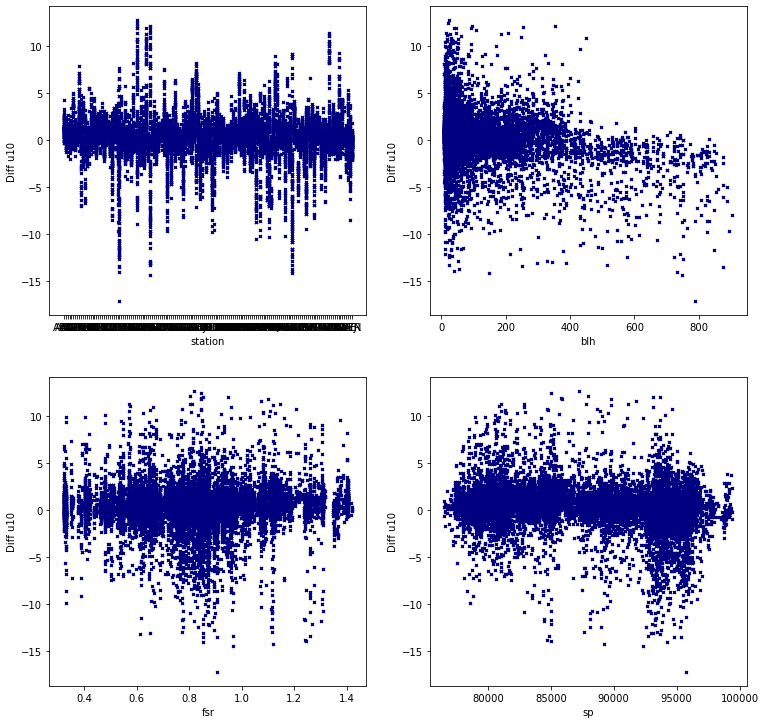

In [24]:
fig, ((ax1, ax2), (ax5, ax6)) = plt.subplots(ncols=2, nrows=2, figsize=(12.5,12.5))
axes = [ax1, ax2, ax5, ax6]
for c, ax in zip(['station','blh', 'fsr', 'sp'], axes):
    ax.scatter(data[c], diff[diff_col], marker='x', s=8, color='navy')
    ax.set_ylabel(f'Diff {diff_col}')
    ax.set_xlabel(c)

KeyError: 'd'

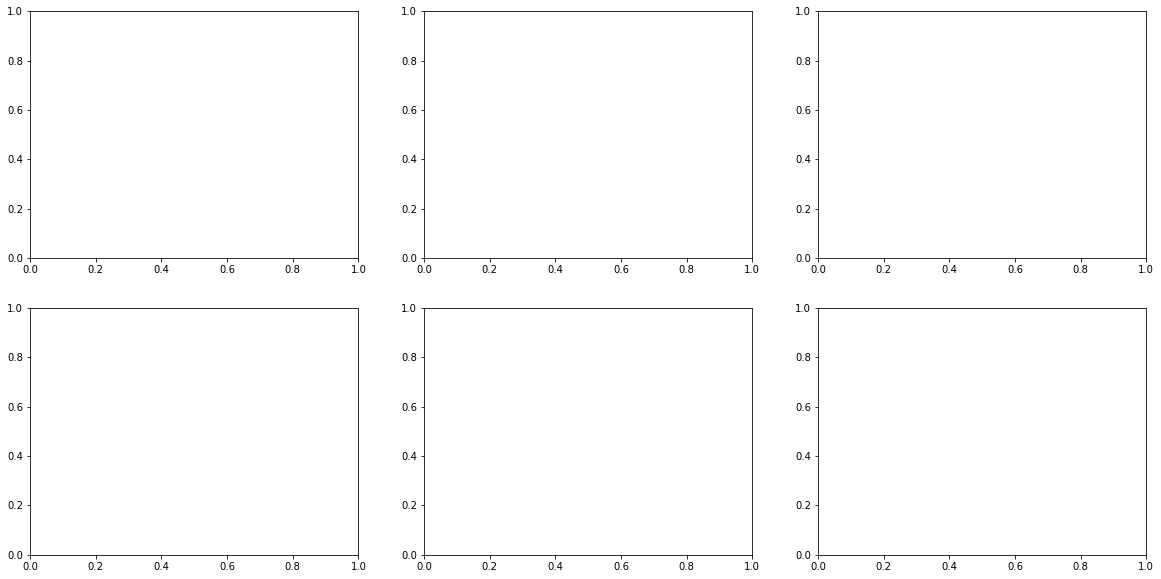

In [25]:
fig, ((ax1, ax2, ax3), (ax5, ax6, ax7)) = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
axes = [ax1, ax2, ax3, ax5, ax6, ax7]
for c, ax in zip(['d', 'z', 'u', 'v', 'w', 'vo'], axes):
    ax.scatter(data[c], diff[diff_col], marker='x', s=8, color='navy')
    ax.set_ylabel(f'Diff {diff_col}')
    ax.set_xlabel(c)

In [ ]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for c, ax in zip(['tpi_500', 'ridge_index_norm', 'ridge_index_dir',
                                                'we_derivative', 'sn_derivative',
                                                'slope', 'aspect'], axes):
    ax.scatter(data[c], diff[diff_col], marker='x', s=8, color='navy')
    ax.set_ylabel(f'Diff {diff_col}')
    ax.set_xlabel(c)

In [ ]:
diff[np.abs(diff['u10'])>1]['u10'].hist(density=True)

In [ ]:
import scipy.stats as stats
import pylab
from scipy.stats.distributions import weibull_min, norm, gamma, genpareto
to_fit = diff[np.abs(diff['u10'])>1]['u10']
to_fit = to_fit[np.abs(to_fit)<15]
gam = norm(*norm.fit(to_fit))
stats.probplot(to_fit, dist=gam, plot=pylab)
pylab.show()

In [ ]:
to_fit = diff[np.abs(diff['u10'])>1]['u10']
to_fit = to_fit[to_fit>=15]
gam = genpareto(*genpareto.fit(to_fit))
stats.probplot(to_fit, dist=gam, plot=pylab)
pylab.show()